# Getting Started with PyFixest

## What is a fixed effect model?

A fixed effect model is a statistical model that includes fixed effects, which are parameters that are estimated to be constant across different groups. 

**Example [Panel Data]:** In the context of panel data, fixed effects are parameters that are constant across different individuals or time. The typical model example is given by the following equation:

$$
Y_{it} = \beta X_{it} + \alpha_i + \psi_t + \varepsilon_{it}
$$

where $Y_{it}$ is the dependent variable for individual $i$ at time $t$, $X_{it}$ is the independent variable, $\beta$ is the coefficient of the independent variable, $\alpha_i$ is the individual fixed effect, $\psi_t$ is the time fixed effect, and $\varepsilon_{it}$ is the error term. The individual fixed effect $\alpha_i$ is a parameter that is constant across time for each individual, while the time fixed effect $\psi_t$ is a parameter that is constant across individuals for each time period.

Note however that, despite the fact that fixed effects are commonly used in panel setting, one does not need a panel data set to work with fixed effects. For example, cluster randomized trials with cluster fixed effects, or wage regressions with worker and firm fixed effects.

In this "quick start" guide, we will show you how to estimate a fixed effect model using the `PyFixest` package. We do not go into the details of the theory behind fixed effect models, but we focus on how to estimate them using `PyFixest`.

## Read Sample Data

In a first step, we load the module and some synthetic example data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lets_plot import LetsPlot

import pyfixest as pf
from pyfixest.did.estimation import did2s
from pyfixest.did.event_study import event_study

LetsPlot.setup_html()

plt.style.use("seaborn-v0_8")

%load_ext watermark
%config InlineBackend.figure_format = "retina"
%watermark --iversions

pyfixest  : 0.22.0
pandas    : 2.2.2
numpy     : 1.26.4
matplotlib: 3.9.1



In [2]:
data = pf.get_data()

data.head()

,Y,Y2,X1,X2,f1,f2,f3,group_id,Z1,Z2,weights
0,NaN,2.357103,0.0,0.457858,15.0,0.0,7.0,9.0,-0.330607,1.054826,0.661478
1,-1.458643,5.163147,NaN,-4.998406,6.0,21.0,4.0,8.0,NaN,-4.113690,0.772732
2,0.169132,0.751140,2.0,1.558480,NaN,1.0,7.0,16.0,1.207778,0.465282,0.990929
3,3.319513,-2.656368,1.0,1.560402,1.0,10.0,11.0,3.0,2.869997,0.467570,0.021123
4,0.134420,-1.866416,2.0,-3.472232,19.0,20.0,6.0,14.0,0.835819,-3.115669,0.790815


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         999 non-null    float64
 1   Y2        1000 non-null   float64
 2   X1        999 non-null    float64
 3   X2        1000 non-null   float64
 4   f1        999 non-null    float64
 5   f2        1000 non-null   float64
 6   f3        1000 non-null   float64
 7   group_id  1000 non-null   float64
 8   Z1        999 non-null    float64
 9   Z2        1000 non-null   float64
 10  weights   1000 non-null   float64
dtypes: float64(11)
memory usage: 86.1 KB


We see that some of our columns have missing data.

## OLS Estimation

We are interested in the relation between the dependent variable `Y` and the independent variables `X1` using a fixed effect model for `group_id`. Let's see how the data looks like:

In [4]:
ax = data.plot(kind="scatter", x="X1", y="Y", c="group_id", colormap="viridis")

We can estimate a fixed effects regression via the `feols()` function. `feols()` has three arguments: a two-sided model formula, the data, and optionally, the type of inference.

In [ ]:
fit = pf.feols(fml="Y ~ X1 | group_id", data=data, vcov="HC1")
type(fit)

pyfixest.estimation.feols_.Feols

The first part of the formula contains the dependent variable and "regular" covariates, while the second part contains fixed effects.

`feols()` returns an instance of the `Fixest` class.

To inspect the results, we can use a summary function or method:

In [ ]:
fit.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.082 |   -12.358 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


Alternatively, the `.summarize` module contains a `summary` function, which can be applied on instances of regression model objects 
or lists of regression model objects. 

In [ ]:
pf.summary(fit)

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.082 |   -12.358 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


You can access individual elements of the summary via dedicated methods: `.tidy()` returns a "tidy" `pd.DataFrame`, 
`.coef()` returns estimated parameters, and `se()` estimated standard errors. Other methods include `pvalue()`, `confint()`
and `tstat()`.

In [ ]:
fit.coef()

Coefficient
X1   -1.019009
Name: Estimate, dtype: float64

In [ ]:
fit.se()

Coefficient
X1    0.082457
Name: Std. Error, dtype: float64

## How to interpret the results?

Let's have a quick d-tour on the intuition behind fixed effects models using the example above. To do so, let us begin by comparing it with a simple OLS model.

In [ ]:
fit_simple = pf.feols("Y ~ X1", data=data, vcov="HC1")

fit_simple.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.227 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.082 |   -12.140 |      0.000 | -1.162 |  -0.838 |
---
RMSE: 2.158 R2: 0.123 


We see that the `X1` coefficient is `-1.0`, which is less than the value from the OLS model above (which was `0.949`). Where is the difference coming from?
Well, in the fixed effect model we are interested in controlling for the feature `group_id`. One possibility to do this is by adding a simple dummy variable for each level of `group_id`.

In [ ]:
fit_dummy = pf.feols("Y ~ X1 + C(group_id) ", data=data, vcov="HC1")

fit_dummy.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept           |      0.760 |        0.288 |     2.642 |      0.008 |  0.195 |   1.325 |
| X1                  |     -1.019 |        0.083 |   -12.240 |      0.000 | -1.182 |  -0.856 |
| C(group_id)[T.1.0]  |      0.380 |        0.450 |     0.844 |      0.399 | -0.504 |   1.264 |
| C(group_id)[T.2.0]  |      0.084 |        0.389 |     0.216 |      0.829 | -0.679 |   0.848 |
| C(group_id)[T.3.0]  |      0.790 |        0.415 |     1.905 |      0.057 | -0.024 |   1.604 |
| C(group_id)[T.4.0]  |     -0.189 |        0.387 |    -0.488 |      0.626 | -0.949 |   0.571 |
| C(group_id)[T.5.0]  |      0.537 |        0.387 |     1.386 |      0.166 | -0.223 |   1.297 |
| C(group_id)[T.6.0]  |      0.307 |        0.39

This is does not scale well! Imagine you have 1000 different levels of `group_id`. You would need to add 1000 dummy variables to your model. This is where fixed effect models come in handy. They allow you to control for these fixed effects without adding all these dummy variables. The way to do it is by a *demeaning procedure*. The idea is to subtract the average value of each level of `group_id` from the respective observations. This way, we control for the fixed effects without adding all these dummy variables. Let's try to do this manually:

In [ ]:
def _demean_column(df: pd.DataFrame, column: str, by: str) -> pd.Series:
    return df[column] - df.groupby(by)[column].transform("mean")


fit_demeaned = pf.feols(
    fml="Y_demeaned ~ X1_demeaned",
    data=data.assign(
        Y_demeaned=lambda df: _demean_column(df, "Y", "group_id"),
        X1_demeaned=lambda df: _demean_column(df, "X1", "group_id"),
    ),
    vcov="HC1",
)

fit_demeaned.summary()

###

Estimation:  OLS
Dep. var.: Y_demeaned, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.003 |        0.068 |     0.041 |      0.968 | -0.130 |   0.136 |
| X1_demeaned   |     -1.019 |        0.083 |   -12.351 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.126 


We get the same results as the fixed effect model `Y1 ~ X | group_id` above. The `PyFixest` package uses a more efficient algorithm to estimate the fixed effect model, but the intuition is the same.

**Updating Coefficients**

You can update the coefficients of a model object via the `update()` method, which may be useful in an online learning setting where data arrives sequentially. 

To see this in action, let us first fit a model on a subset of the data:

In [ ]:
data_subsample = data.sample(frac=0.5)
m = pf.feols("Y ~ X1 + X2", data=data_subsample)
# current coefficient vector
m._beta_hat

array([ 0.93422205, -1.06377342, -0.15705189])

Then sample 5 new observations and update the model with the new data. The update rule is 

$$
\hat{\beta}_{n+1} = \hat{\beta}_n + (X_{n+1}' X_{n+1})^{-1} x_{n+1} + (y_{n+1} - x_{n+1} \hat{\beta}_n) 
$$

for a new observation $(x_{n+1}, y_{n+1})$.

In [ ]:
new_points_id = np.random.choice(list(set(data.index) - set(data_subsample.index)), 5)
X_new, y_new = (
    np.c_[np.ones(len(new_points_id)), data.loc[new_points_id][["X1", "X2"]].values],
    data.loc[new_points_id]["Y"].values,
)
m.update(X_new, y_new)

array([ 0.92884819, -1.05974406, -0.15102478])

We verify that we get the same results if we had estimated the model on the appended data.

In [ ]:
pf.feols(
    "Y ~ X1 + X2", data=data.loc[data_subsample.index.append(pd.Index(new_points_id))]
).coef().values

array([ 0.92884819, -1.05974406, -0.15102478])

## Standard Errors and Inference

Supported covariance types are "iid", "HC1-3", CRV1 and CRV3 (up to two-way clustering).

**Why do we have so many different types of standard errors?**

The standard errors of the coefficients are crucial for inference. They tell us how certain we can be about the estimated coefficients. In the presence of heteroskedasticity (a situation which typically arises with cross-sectional data), the standard OLS standard errors are biased. The `pyfixest` package provides several types of standard errors that are robust to heteroskedasticity.

- `iid`: assumes that the error variance is spherical, i.e. errors are homoskedastic and not correlated (independent and identically distributed errors have a spherical error variance).
- `HC1-3`: heteroskedasticity-robust standard errors according to White (1980) and MacKinnon and White (1985). See [Econometric Computing with HC and HAC
Covariance Matrix Estimators](https://cran.r-project.org/web/packages/sandwich/vignettes/sandwich.pdf) from the [`sandwich`](https://cran.r-project.org/web/packages/sandwich/) package for more details.
- `CRV1` and `CRV3`: cluster robust standard errors according to Cameron, Gelbach, and Miller (2011). See [A Practitioner’s Guide to Cluster-Robust Inference](https://cameron.econ.ucdavis.edu/research/Cameron_Miller_JHR_2015_February.pdf).  For   `CRV1` and `CRV3` one should pass a dictionaty of the form `{"CRV1": "clustervar"}`. 

Inference can be adjusted "on-the-fly" via the `.vcov()` method:

In [ ]:
fit.vcov({"CRV1": "group_id + f2"}).summary()

fit.vcov({"CRV3": "group_id"}).summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.121 |    -8.450 |      0.000 | -1.272 |  -0.766 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  CRV3
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.125 |    -8.179 |      0.000 | -1.281 |  -0.757 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


The estimated covariance matrix is available as an attribute of the `Feols` object called `._vcov`.

**Inference via the Wild Bootstrap**

It is also possible to run a wild (cluster) bootstrap after estimation (via the [wildboottest module](https://github.com/py-econometrics/wildboottest), see [MacKinnon, J. G., Nielsen, M. Ø., & Webb, M. D. (2023). Fast and reliable jackknife and bootstrap methods for cluster-robust inference. Journal of Applied Econometrics, 38(5), 671–694.](http://qed.econ.queensu.ca/pub/faculty/mackinnon/working-papers/qed_wp_1485.pdf)):

In [ ]:
fit2 = pf.feols(fml="Y ~ X1", data=data, vcov={"CRV1": "group_id"})
fit2.wildboottest(param="X1", reps=999)

param                             X1
t value           -8.567586579080423
Pr(>|t|)                         0.0
bootstrap_type                    11
inference              CRV(group_id)
impose_null                     True
dtype: object

**Non-Parametric Bootstrap Inference**

Via the `bootstrap()` method, you can run a "standard" non-parametric bootsrap. If your regression method employs cluster 
robust standard errors, the method will run a block bootstrap. If the function argument `inplace` is set to `True`, the method
will uppdate the covariance matrix stored in the `Feols` instance and all associated inferential parameters. If `False` (the default), 
the method will return a bootstrapped variance-covariance matrix. 

In [ ]:
fit2.bootstrap(reps = 1000, seed = 9292)

100%|██████████| 1000/1000 [00:20<00:00, 49.86it/s]


array([[ 0.01590017, -0.01321583],
       [-0.01321583,  0.01448196]])

**The Causal Cluster Variance Estimator**

Additionally, `PyFixest` supports the causal cluster variance estimator following [Abadie et al. (2023)](https://academic.oup.com/qje/article/138/1/1/6750017). Let's look into it with another data set:

In [ ]:
df = pd.read_stata("http://www.damianclarke.net/stata/census2000_5pc.dta")

df.head()

We can take a look into the variables of interest:

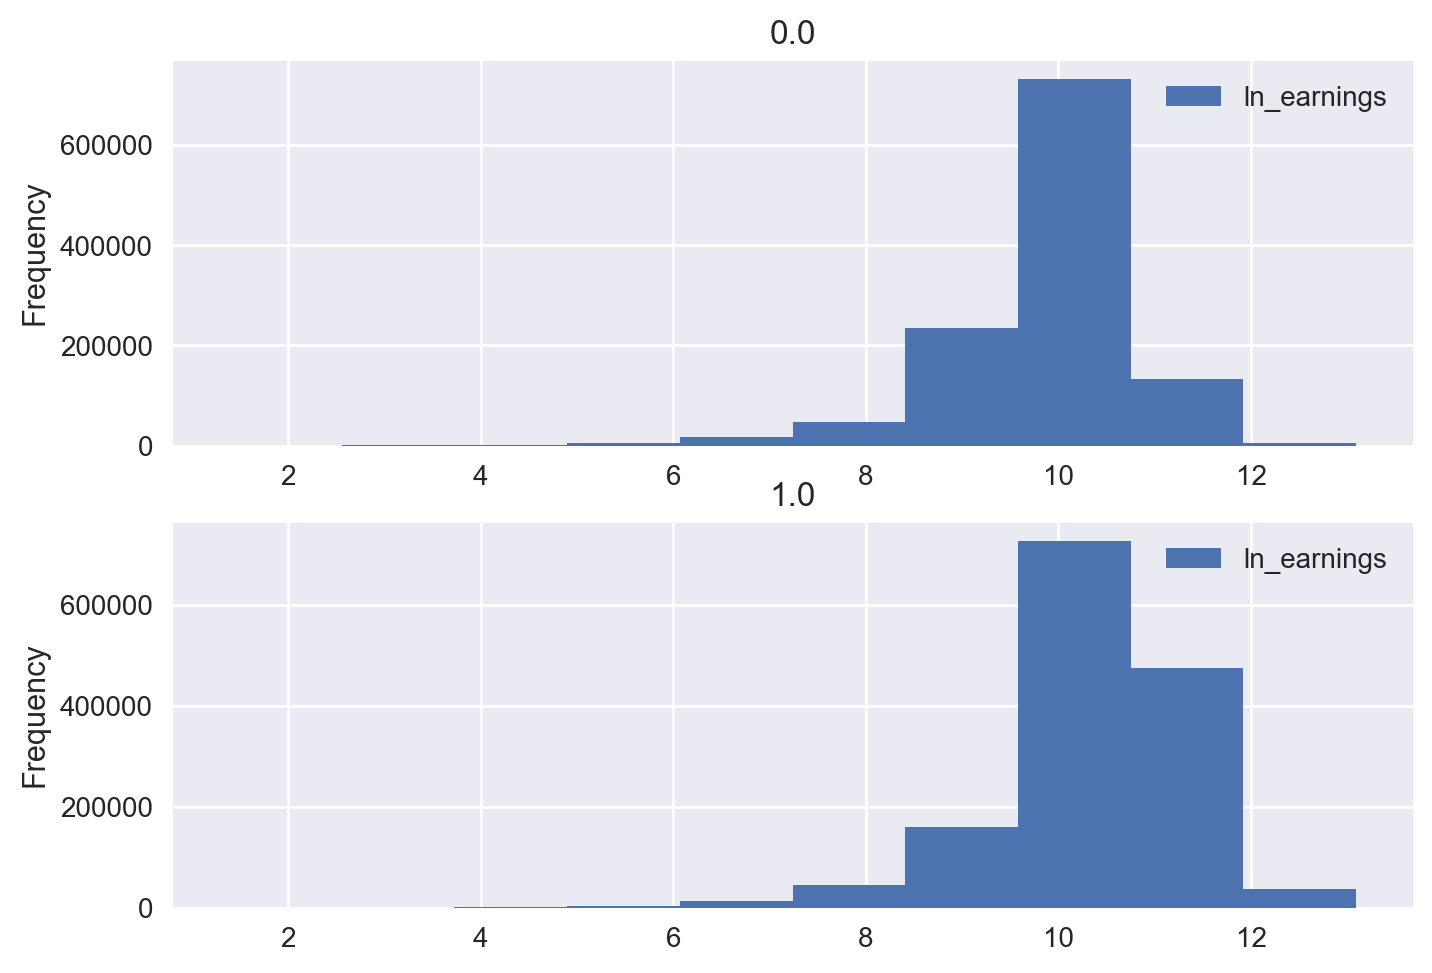

In [ ]:
axes = df.plot.hist(column=["ln_earnings"], by=["college"])

Now we can estimate the model `ln_earnings ~ college` where we cluster the standard errors at the state level:

In [ ]:
fit3 = pf.feols("ln_earnings ~ college", vcov={"CRV1": "state"}, data=df)
fit3.ccv(treatment="college", pk=0.05, n_splits=2, seed=929)

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
CCV,0.4656425903701483,0.00348,133.820078,0.0,0.458657,0.472628
CRV1,0.465643,0.027142,17.155606,0.0,0.411152,0.520133


**Randomization Inference**

You can also conduct inference via randomization inference [(see Heß, Stata Journal 2017)](https://hesss.org/ritest.pdf).
`PyFixest` supports random and cluster random sampling. 

In [ ]:
fit2.ritest(resampvar="X1=0", reps=1000, cluster="group_id")

H0                                     X1=0
ri-type                     randomization-c
Estimate                 -1.000085840074156
Pr(>|t|)                                0.0
Std. Error (Pr(>|t|))                   0.0
2.5% (Pr(>|t|))                         0.0
97.5% (Pr(>|t|))                        0.0
Cluster                            group_id
dtype: object

**Multiple Testing Corrections: Bonferroni and Romano-Wolf**

To correct for multiple testing, p-values can be adjusted via either the [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction) or the method by Romano and Wolf (2005), see for example [The Romano-Wolf Multiple Hypothesis
Correction in Stata](https://docs.iza.org/dp12845.pdf).

In [ ]:
pf.bonferroni([fit, fit2], param="X1").round(3)

,est0,est1
Estimate,-1.019,-1.000
Std. Error,0.125,0.117
t value,-8.179,-8.568
Pr(>|t|),0.000,0.000
2.5%,-1.281,-1.245
97.5%,-0.757,-0.755
Bonferroni Pr(>|t|),0.000,0.000


In [ ]:
pf.rwolf([fit, fit2], param="X1", reps=9999, seed=1234).round(3)

,est0,est1
Estimate,-1.019,-1.000
Std. Error,0.125,0.117
t value,-8.179,-8.568
Pr(>|t|),0.000,0.000
2.5%,-1.281,-1.245
97.5%,-0.757,-0.755
RW Pr(>|t|),0.000,0.000


**Joint Confidence Intervals**

Simultaneous confidence bands for a vector of parameters can be computed via the `joint_confint()` method. See [Simultaneous confidence bands: Theory, implementation, and an application to SVARs](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.2656) for background.

In [ ]:
fit_ci = pf.feols("Y ~ X1+ C(f1)", data=data)
fit_ci.confint(joint=True).head()

,0.025%,0.975%
Intercept,-0.426374,1.404285
X1,-1.160831,-0.738051
C(f1)[T.1.0],1.383661,3.781638
C(f1)[T.2.0],-2.839467,-0.324401
C(f1)[T.3.0],-1.608952,0.984284


## Panel Data Example: Causal Inference for the Brave and True

In this example we replicate the results of the great (freely available reference!) [Causal Inference for the Brave and True - Chapter 14](https://matheusfacure.github.io/python-causality-handbook/14-Panel-Data-and-Fixed-Effects.html). Please refer to the original text for a detailed explanation of the data.

In [ ]:
data_path = "https://raw.githubusercontent.com/bashtage/linearmodels/main/linearmodels/datasets/wage_panel/wage_panel.csv.bz2"
data_df = pd.read_csv(data_path)

data_df.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


The objective is to estimate the effect of the variable `married` on the variable `lwage` using a fixed effect model on the entity variable `nr` and the time variable `year`.

In [ ]:
panel_fit = pf.feols(
    fml="lwage ~ expersq + union + married + hours | nr + year",
    data=data_df,
    vcov={"CRV1": "nr + year"},
)

panel_fit.summary()

###

Estimation:  OLS
Dep. var.: lwage, Fixed effects: nr+year
Inference:  CRV1
Observations:  4360

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| expersq       |     -0.006 |        0.001 |    -8.157 |      0.000 | -0.008 |  -0.004 |
| union         |      0.073 |        0.023 |     3.189 |      0.015 |  0.019 |   0.127 |
| married       |      0.048 |        0.018 |     2.694 |      0.031 |  0.006 |   0.089 |
| hours         |     -0.000 |        0.000 |    -3.830 |      0.006 | -0.000 |  -0.000 |
---
RMSE: 0.324 R2: 0.631 R2 Within: 0.047 


We obtain the same results as in the book!

## Instrumental Variables (IV) Estimation 

It is also possible to estimate [instrumental variable models](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) with *one* endogenous variable and (potentially multiple) instruments. 

In general, the syntax for IV is `depvar ~ exog.vars | fixef effects | endog.vars ~ instruments`.

In [ ]:
iv_fit = pf.feols(fml="Y2 ~ 1 | f1 + f2 | X1 ~ Z1 + Z2", data=data)
iv_fit.summary()

###

Estimation:  IV
Dep. var.: Y2, Fixed effects: f1+f2
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.600 |        0.333 |    -4.801 |      0.000 | -2.282 |  -0.919 |
---



If the model does not contain any fixed effects, just drop the second part of the formula above:

In [ ]:
pf.feols(fml="Y ~ 1 | X1 ~ Z1 + Z2", data=data).summary()

###

Estimation:  IV
Dep. var.: Y, Fixed effects: 
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.911 |        0.156 |     5.843 |      0.000 |  0.605 |   1.217 |
| X1            |     -0.993 |        0.134 |    -7.398 |      0.000 | -1.256 |  -0.730 |
---



You can access the first stage regression object via the `._model_1st_stage` attribute: 

In [ ]:
pf.etable([iv_fit._model_1st_stage, iv_fit])

,est1,est2
depvar,Y,Y2
Z1,0.403*** (0.011),
Z2,-0.003 (0.006),
X1,,-1.600*** (0.333)
f1,x,x
f2,x,x
R2,0.425,-
S.E. type,by: f1,by: f1
Observations,996,998


You can access the F-Statistic of the first stage via the `_f_stat_1st_stage` attribute:

In [ ]:
iv_fit._f_stat_1st_stage

692.3044112624756

Via the `IV_Diag` method, you can compute additional IV Diagnostics, as the **effective F-statistic** following Olea & Pflueger (2013): 

In [ ]:
iv_fit.IV_Diag()
iv_fit._eff_F

533.5670484892216

IV estimation with multiple endogenous variables and multiple estimation syntax is currently not supported.

## Poisson Regression 

It is possible to estimate Poisson Regressions (for example, to model count data). We can showcase this feature with another synthetic data set.

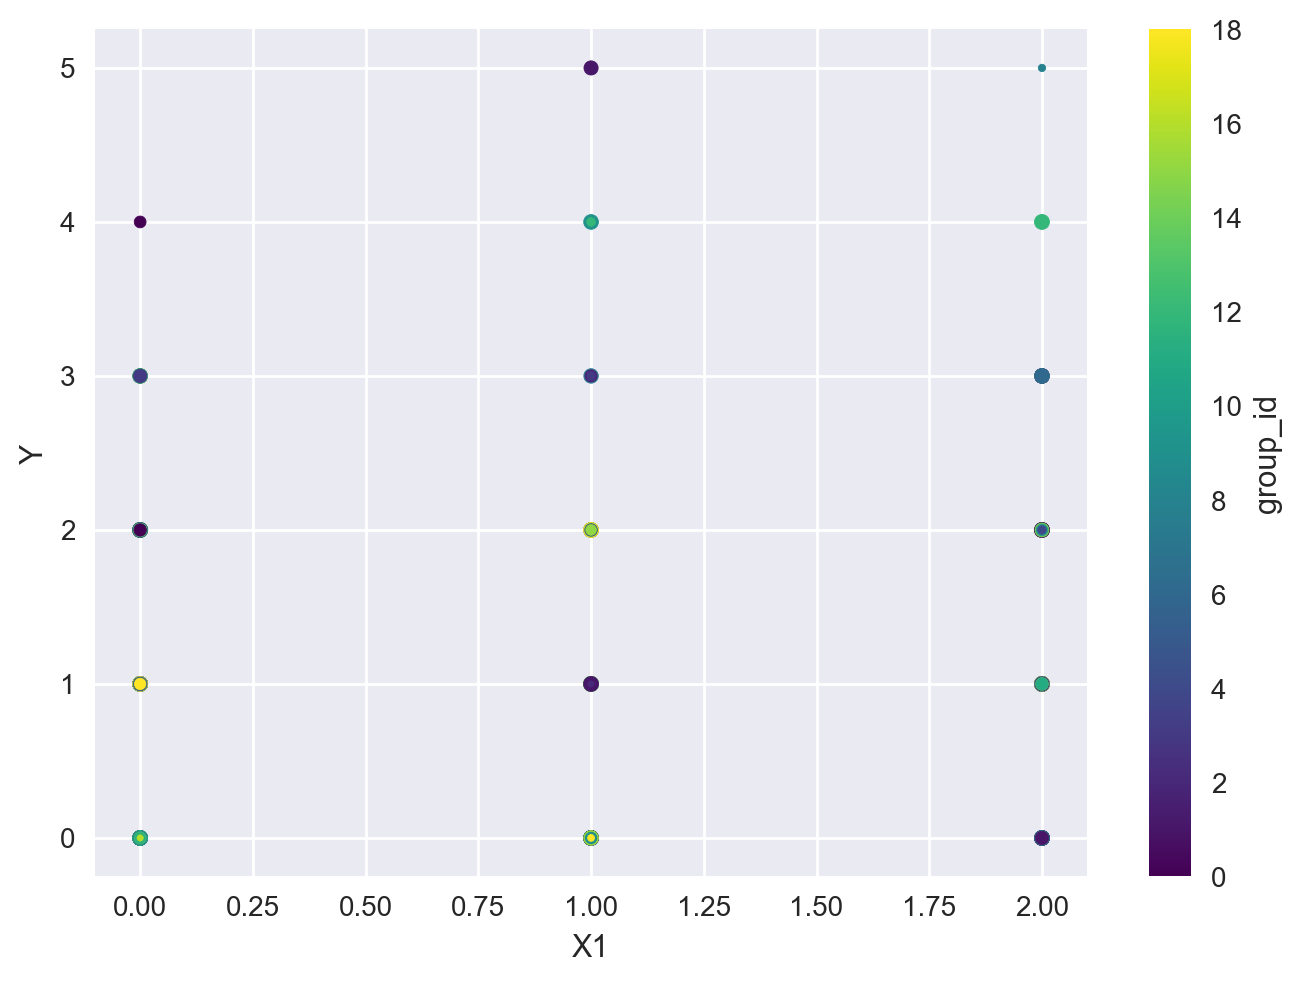

In [ ]:
pois_data = pf.get_data(model="Fepois")

ax = pois_data.plot(
    kind="scatter",
    x="X1",
    y="Y",
    c="group_id",
    colormap="viridis",
    s="f2",
)

In [ ]:
pois_fit = pf.fepois(fml="Y ~ X1 | group_id", data=pois_data, vcov={"CRV1": "group_id"})
pois_fit.summary()

###

Estimation:  Poisson
Dep. var.: Y, Fixed effects: group_id
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |      0.004 |        0.032 |     0.119 |      0.905 | -0.060 |   0.067 |
---
Deviance: 1126.202 


## Tests of Multiple Hypothesis / Wald Tests

You can test multiple hypotheses simultaneously via the `wald_test` method.

In [ ]:
fit = pf.feols("Y ~ X1 + X2 | f1", data=data)

For example, to test the joint null hypothesis of $X_{1} = 0$ and $X_{2} = 0$ vs the alternative that $X_{1} \neq 0$ or $X_{2} \neq 0$, we would run 

In [ ]:
fit.wald_test(R=np.eye(2))

statistic    1.464780e+02
pvalue       6.661338e-16
dtype: float64

Alternatively, suppose we wanted to test a more complicated joint null hypothesis:  $X_{1} + 2X_{2} = 2.0$ and $X_{2} = 1.0$. To do so, we would define $R$ and $q$ as 

In [ ]:
R1 = np.array([[1, 2], [0, 1]])
q1 = np.array([2.0, 1.0])
fit.wald_test(R=R1, q=q1)

c:\Users\alexa\AppData\Local\pypoetry\Cache\virtualenvs\pyfixest-pKOwcWPT-py3.10\lib\site-packages\pyfixest\estimation\feols_.py:939: UserWarning: Distribution changed to chi2, as R is not an identity matrix and q is not a zero vector.
  warnings.warn(


statistic    4273.462101
pvalue          0.000000
dtype: float64

## Multiple Estimation 

`PyFixest` supports a range of multiple estimation functionality: `sw`, `sw0`, `csw`, `csw0`, and multiple dependent variables. The meaning of these options is explained in the [Multiple Estimations](https://lrberge.github.io/fixest/articles/multiple_estimations.html) vignette of the `fixest` package:

> - `sw`: this function is replaced sequentially by each of its arguments. For example, `y ~ x1 + sw(x2, x3)` leads to two estimations: `y ~ x1 + x2` and `y ~ x1 + x3`.
> - `sw0`: identical to sw but first adds the empty element. E.g. `y ~ x1 + sw0(x2, x3)` leads to three estimations: `y ~ x1`, `y ~ x1 + x2` and `y ~ x1 + x3`.
> - `csw`: it stands for cumulative stepwise. It adds to the formula each of its arguments sequentially. E.g. `y ~ x1 + csw(x2, x3)` will become `y ~ x1 + x2` and `y ~ x1 + x2 + x3`.
> - `csw0`: identical to csw but first adds the empty element. E.g. `y ~ x1 + csw0(x2, x3)` leads to three estimations: `y ~ x1`, `y ~ x1 + x`2 and `y ~ x1 + x2 + x3`.

If multiple regression syntax is used, 
`feols()` and `fepois` returns an instance of a `FixestMulti` object, which essentially consists of a dicionary of `Fepois` or [Feols](/reference/Feols.qmd) instances.

In [ ]:
multi_fit = pf.feols(fml="Y ~ X1 | csw0(f1, f2)", data=data, vcov="HC1")
multi_fit

In [ ]:
multi_fit.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.227 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.082 |   -12.140 |      0.000 | -1.162 |  -0.838 |
---
RMSE: 2.158 R2: 0.123 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -0.949 |        0.066 |   -14.318 |      0.000 | -1.080 |  -0.819 |
---
RMSE: 1.73 R2: 0.437 R2 Within: 0.161 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate 

Alternatively, you can look at the estimation results via the `etable()` method:

In [ ]:
multi_fit.etable()

,est1,est2,est3
depvar,Y,Y,Y
Intercept,0.919*** (0.112),,
X1,-1.000*** (0.082),-0.949*** (0.066),-0.919*** (0.058)
f1,-,x,x
f2,-,-,x
R2,0.123,0.437,0.609
S.E. type,hetero,hetero,hetero
Observations,998,997,997


You can access an individual model by its name - i.e. a formula - via the `all_fitted_models` attribute.

In [ ]:
multi_fit.all_fitted_models["Y~X1"].tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
Intercept,0.918518,0.111651,8.226703,6.661338e-16,0.699420,1.137616
X1,-1.000086,0.082378,-12.140170,0.000000e+00,-1.161741,-0.838431


or equivalently via the `fetch_model` method:

In [ ]:
multi_fit.fetch_model(0).tidy()

Model:  Y~X1


,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
Intercept,0.918518,0.111651,8.226703,6.661338e-16,0.699420,1.137616
X1,-1.000086,0.082378,-12.140170,0.000000e+00,-1.161741,-0.838431


Here, `0` simply fetches the first model stored in the `all_fitted_models` dictionary, `1` the second etc.

Objects of type `Fixest` come with a range of additional methods: `tidy()`, `coef()`, `vcov()` etc, which 
essentially loop over the equivalent methods of all fitted models. E.g. `Fixest.vcov()` updates inference for all 
models stored in `Fixest`.

In [ ]:
multi_fit.vcov("iid").summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.214 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.085 |   -11.802 |      0.000 | -1.166 |  -0.834 |
---
RMSE: 2.158 R2: 0.123 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  iid
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -0.949 |        0.069 |   -13.846 |      0.000 | -1.084 |  -0.815 |
---
RMSE: 1.73 R2: 0.437 R2 Within: 0.161 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  iid
Observations:  997

| Coefficient   |   Estimate 

If you have estimated multiple models without multiple estimation syntax and still want to compare them, you can use the `etable()` function: 

In [ ]:
pf.etable([fit, fit2])

,est1,est2
depvar,Y,Y
X1,-0.950*** (0.067),-1.000*** (0.117)
X2,-0.174*** (0.018),
Intercept,,0.919*** (0.121)
f1,x,-
R2,0.489,0.123
S.E. type,by: f1,by: group_id
Observations,997,998


## Visualization 

`PyFixest` provides two functions to visualize the results of a regression: `coefplot` and `iplot`.

In [ ]:
multi_fit.coefplot().show()

You can use a `matplotlib` backend as well: 

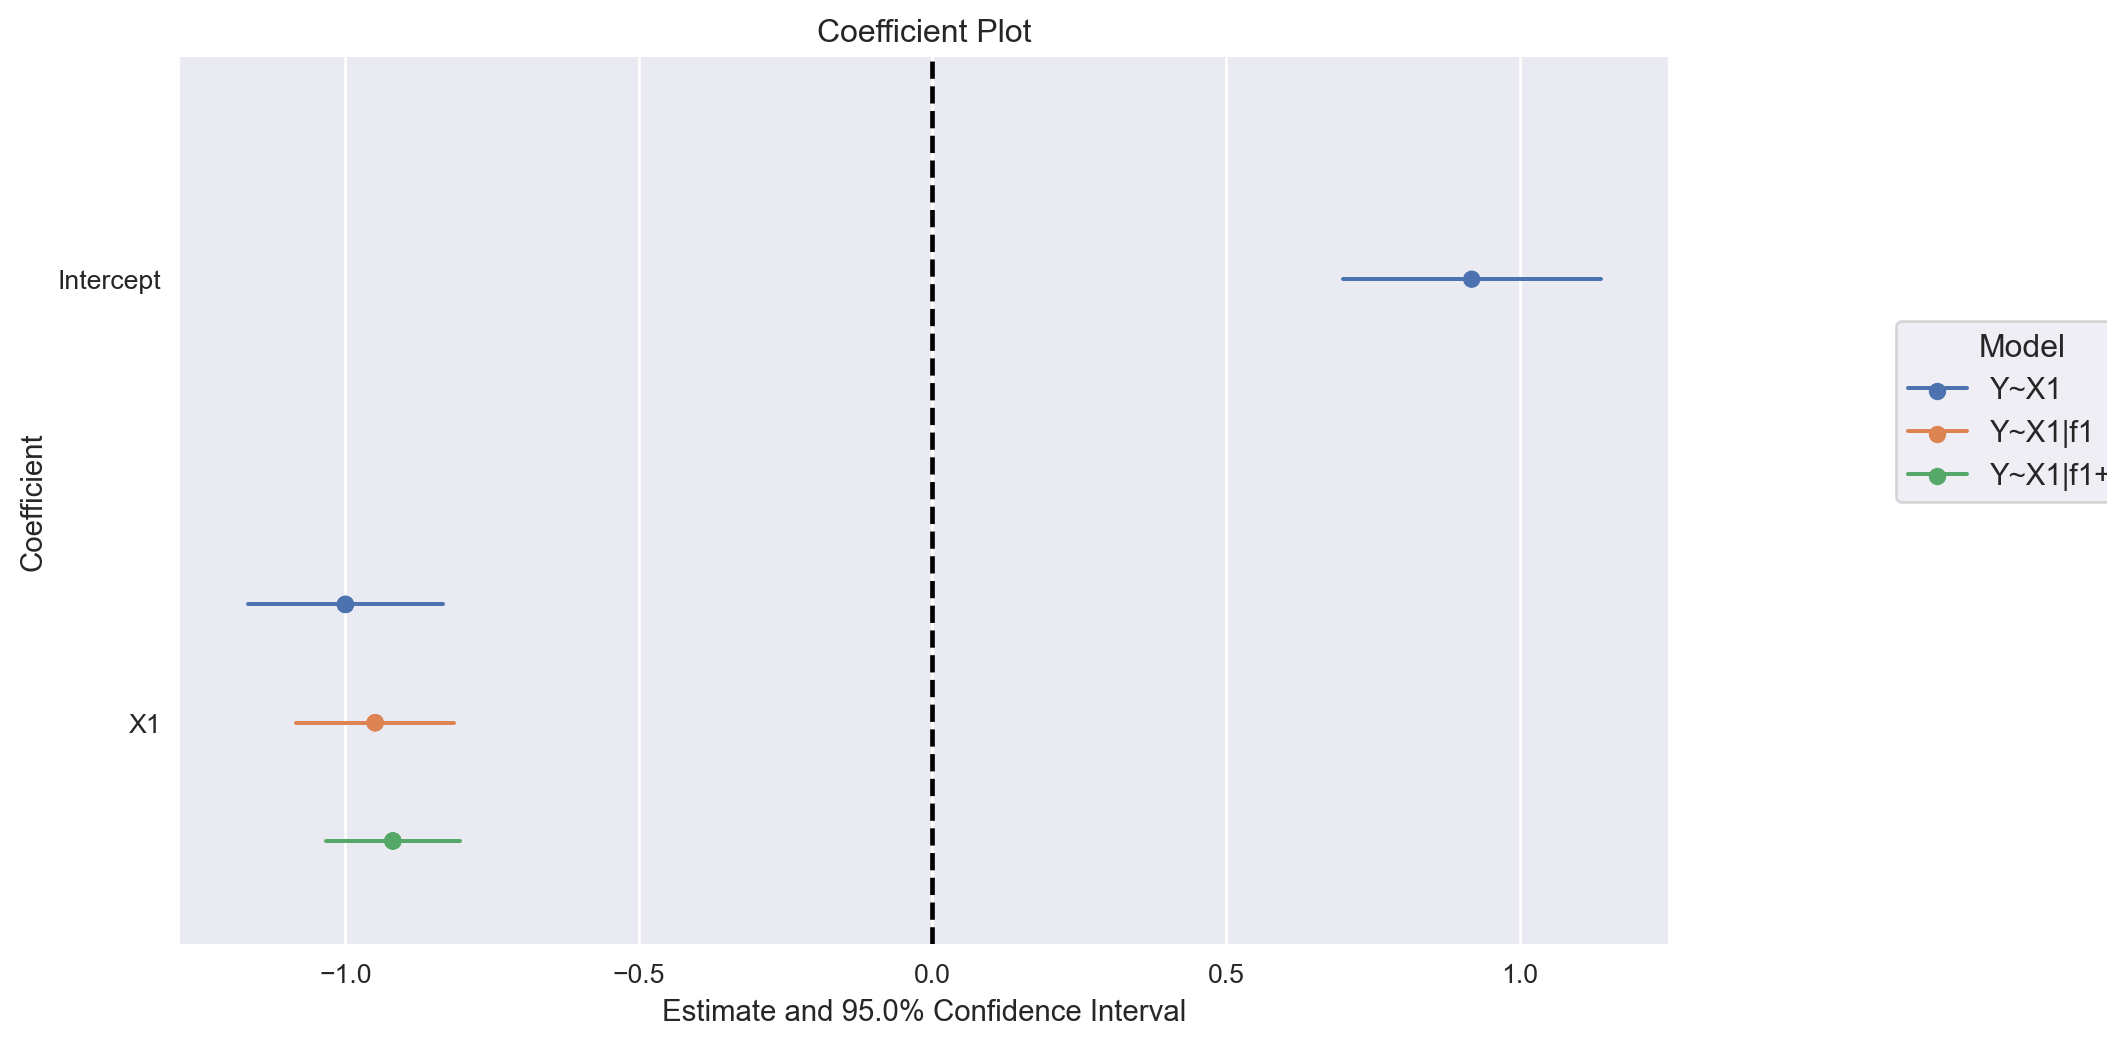

In [ ]:
multi_fit.coefplot(plot_backend="matplotlib")

## Difference-in-Differences / Event Study Designs

`PyFixest` supports eventy study designs via two-way fixed effects and Gardner's 2-stage estimator. 

In [ ]:
url = "https://raw.githubusercontent.com/py-econometrics/pyfixest/master/pyfixest/did/data/df_het.csv"
df_het = pd.read_csv(url)

df_het.head()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
0,1,33,Group 2,7.043016,2010,1990,0.066159,False,-20.0,-6,-0.086466,0,0.0,7.022709
1,1,33,Group 2,7.043016,2010,1991,-0.030980,False,-19.0,-6,0.766593,0,0.0,7.778628
2,1,33,Group 2,7.043016,2010,1992,-0.119607,False,-18.0,-6,1.512968,0,0.0,8.436377
3,1,33,Group 2,7.043016,2010,1993,0.126321,False,-17.0,-6,0.021870,0,0.0,7.191207
4,1,33,Group 2,7.043016,2010,1994,-0.106921,False,-16.0,-6,-0.017603,0,0.0,6.918492


In [ ]:
fit_did2s = did2s(
    df_het,
    yname="dep_var",
    first_stage="~ 0 | state + year",
    second_stage="~i(rel_year,ref= -1.0)",
    treatment="treat",
    cluster="state",
)


fit_twfe = pf.feols(
    "dep_var ~ i(rel_year,ref = -1.0) | state + year",
    df_het,
    vcov={"CRV1": "state"},
)

pf.iplot(
    [fit_did2s, fit_twfe], coord_flip=False, figsize=(900, 400), title="TWFE vs DID2S"
)

The `event_study()` function provides a common API for several event study estimators.

In [ ]:
fit_twfe = event_study(
    data=df_het,
    yname="dep_var",
    idname="state",
    tname="year",
    gname="g",
    estimator="twfe",
)

fit_did2s = event_study(
    data=df_het,
    yname="dep_var",
    idname="state",
    tname="year",
    gname="g",
    estimator="did2s",
)

pf.etable([fit_twfe, fit_did2s])

,est1,est2
depvar,dep_var,dep_var_hat
ATT,2.135*** (0.044),2.152*** (0.048)
state,x,-
year,x,-
R2,0.758,0.338
S.E. type,by: state,CRV1
Observations,46500,46500


For more details see the vignette on [Difference-in-Differences Estimation](https://py-econometrics.github.io/pyfixest/difference-in-differences.html).